In [1]:
# Cell 1: Import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1462, 9)


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [2]:
# Cell 2: Data preparation
# Check for missing values
print("Missing values before processing:")
print(df.isnull().sum())

# Create a copy for processing
data = df.copy()

# Separate categorical and numerical features
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Remove target from numerical cols
if 'converted' in numerical_cols:
    numerical_cols.remove('converted')

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Fill missing values
for col in categorical_cols:
    data[col] = data[col].fillna('NA')

for col in numerical_cols:
    data[col] = data[col].fillna(0.0)

print("\nMissing values after processing:")
print(data.isnull().sum())

Missing values before processing:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Categorical columns: ['lead_source', 'industry', 'employment_status', 'location']
Numerical columns: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

Missing values after processing:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [3]:
# Cell 3: Split the data
# Split the data into train/validation/test with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

print(f"Train set: {df_train.shape[0]} samples")
print(f"Validation set: {df_val.shape[0]} samples")
print(f"Test set: {df_test.shape[0]} samples")

# Prepare target variables
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

# Remove target from features
del df_train['converted']
del df_val['converted']
del df_test['converted']

Train set: 876 samples
Validation set: 293 samples
Test set: 293 samples


In [4]:
# Cell 4: Question 1 - ROC AUC feature importance
numerical_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for var in numerical_vars:
    scores = df_train[var].values
    
    # If AUC < 0.5, invert the variable
    auc = roc_auc_score(y_train, scores)
    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)
    
    auc_scores[var] = auc
    print(f"{var}: AUC = {auc:.4f}")

best_var = max(auc_scores, key=auc_scores.get)
best_auc = auc_scores[best_var]
print(f"\nQuestion 1: Numerical variable with highest AUC: {best_var} (AUC: {best_auc:.4f})")

lead_score: AUC = 0.6145
number_of_courses_viewed: AUC = 0.7636
interaction_count: AUC = 0.7383
annual_income: AUC = 0.5520

Question 1: Numerical variable with highest AUC: number_of_courses_viewed (AUC: 0.7636)


In [5]:
# Cell 5: Question 2 - Training the model
# Prepare features for DictVectorizer
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

# Apply one-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_val_pred = model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc_val = roc_auc_score(y_val, y_val_pred)
print(f"Question 2: AUC on validation dataset: {auc_val:.3f}")

Question 2: AUC on validation dataset: 0.817


Question 3: Threshold where precision and recall intersect: 0.980


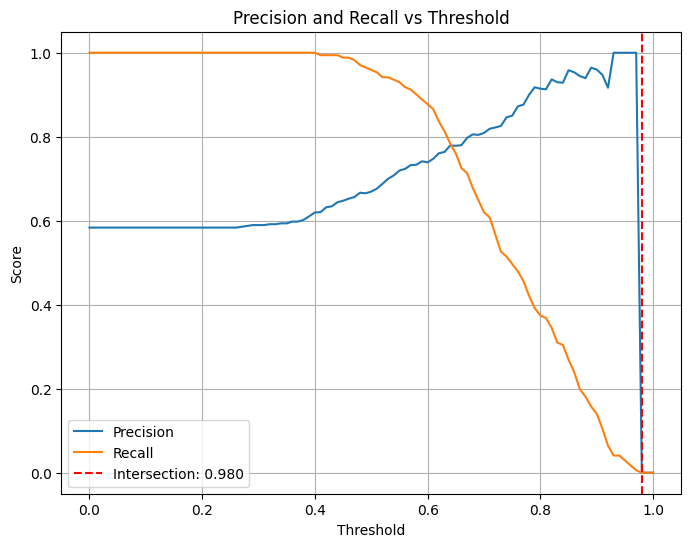

In [6]:
# Cell 6: Question 3 - Precision and Recall
# Calculate precision and recall for different thresholds
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

for t in thresholds:
    y_pred = (y_val_pred >= t).astype(int)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    precisions.append(prec)
    recalls.append(rec)

# Find intersection point
intersection_threshold = None
min_diff = float('inf')

for i, (p, r) in enumerate(zip(precisions, recalls)):
    diff = abs(p - r)
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = thresholds[i]

print(f"Question 3: Threshold where precision and recall intersect: {intersection_threshold:.3f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(x=intersection_threshold, color='red', linestyle='--', label=f'Intersection: {intersection_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

Question 4: Threshold with maximum F1 score: 0.57
Maximum F1 score: 0.8125


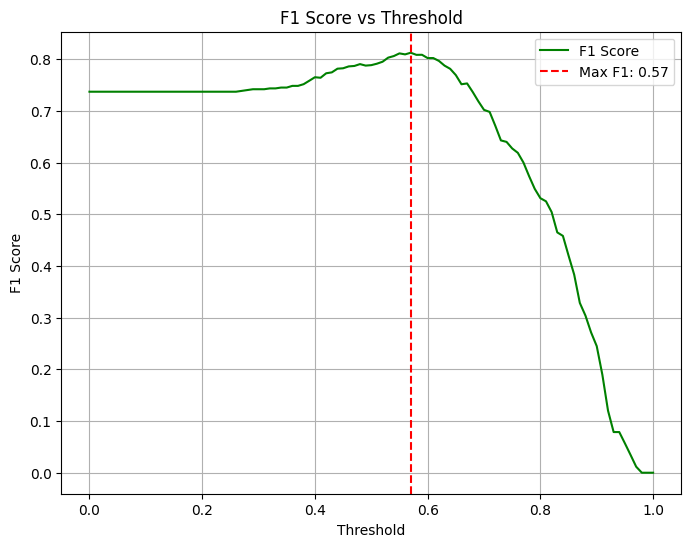

In [7]:
# Cell 7: Question 4 - F1 score
# Calculate F1 score for different thresholds
f1_scores = []

for t in thresholds:
    y_pred = (y_val_pred >= t).astype(int)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    f1_scores.append(f1)

# Find threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

print(f"Question 4: Threshold with maximum F1 score: {max_f1_threshold:.2f}")
print(f"Maximum F1 score: {max_f1_value:.4f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', label=f'Max F1: {max_f1_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Cell 8: Question 5 - 5-Fold CV
def train_logistic_regression(df_train, y_train, C=1.0):
    train_dict = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict_logistic_regression(df, dv, model):
    dict_data = df.to_dict(orient='records')
    X = dv.transform(dict_data)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

# 5-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx].copy()
    df_val_fold = df_full_train.iloc[val_idx].copy()
    
    y_train_fold = df_train_fold.converted.values
    y_val_fold = df_val_fold.converted.values
    
    del df_train_fold['converted']
    del df_val_fold['converted']
    
    dv, model = train_logistic_regression(df_train_fold, y_train_fold, C=1.0)
    y_pred_fold = predict_logistic_regression(df_val_fold, dv, model)
    
    auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
    scores.append(auc_fold)

print("5-Fold CV Scores:", [f"{score:.4f}" for score in scores])
print(f"Mean AUC: {np.mean(scores):.4f}")
print(f"Standard deviation: {np.std(scores):.4f}")

std_dev = np.std(scores)
print(f"\nQuestion 5: Standard deviation of scores across folds: {std_dev:.4f}")

5-Fold CV Scores: ['0.8061', '0.8714', '0.7754', '0.8018', '0.8558']
Mean AUC: 0.8221
Standard deviation: 0.0358

Question 5: Standard deviation of scores across folds: 0.0358


In [9]:
# Cell 9: Question 6 - Hyperparameter Tuning
C_values = [0.000001, 0.001, 1]
results = []

for C in tqdm(C_values):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx].copy()
        df_val_fold = df_full_train.iloc[val_idx].copy()
        
        y_train_fold = df_train_fold.converted.values
        y_val_fold = df_val_fold.converted.values
        
        del df_train_fold['converted']
        del df_val_fold['converted']
        
        dv, model = train_logistic_regression(df_train_fold, y_train_fold, C=C)
        y_pred_fold = predict_logistic_regression(df_val_fold, dv, model)
        
        auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
        scores.append(auc_fold)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results.append((C, mean_score, std_score))
    print(f"C={C}: Mean AUC = {mean_score:.3f} ± {std_score:.3f}")

# Find best C
best_result = max(results, key=lambda x: (x[1], -x[2]))  # Max mean, min std if tie
best_C = best_result[0]
best_mean = best_result[1]
best_std = best_result[2]

print(f"\nQuestion 6: Best C value: {best_C}")
print(f"Best mean AUC: {best_mean:.3f} ± {best_std:.3f}")

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06: Mean AUC = 0.560 ± 0.024
C=0.001: Mean AUC = 0.867 ± 0.029
C=1: Mean AUC = 0.822 ± 0.036

Question 6: Best C value: 0.001
Best mean AUC: 0.867 ± 0.029
